In [1]:
from collections import Counter, deque
import os.path
import json
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

sys.path.append(r'C:\Users\hornu\OneDrive\Documents\repos\chart-singles\christmas\utils')
sys.path.append(r'C:\Users\hornu\OneDrive\Documents\repos\similarities\tversky\source')

from tversky_index import calculate_pairwise_tversky
from plot_utils import plot_scatter_histo, plot_linear_graph, plot_histo, plot_linear_graph_with_colors

from calc_utils import calculate_backward_resolved_number_ratio, calculate_weighted_jaccard
from calc_utils import calculate_backward_number_ratio, calculate_forward_number_ratio

from io_utils import load_from_json, load_dict_from_json

A simple mathematical formalism and a framework composed of the components thereof is presented to analyse recurring singles in the UK charts. We test this framework on the Christmas singles. It will also be shown that there is no trivial way to decide whether a single is intended to be a song for yuletide without using any information sourced from outside of the chart.


## Prelude

I have been looking at the UK singes charts. In the [first post](https://bhornung.github.io/python/2019/02/22/uk-charts-1.html) the record labels were investigated. I set off to analyse the singles themselves. I loaded the data to a dataframe `chart_df`:

In [2]:
path_to_chart_data = r'C:\Users\hornu\OneDrive\Documents\repos\chart-singles\data\encoded-singles\charts\singles-chart-2d.txt'
path_to_chart_index = r'C:\Users\hornu\OneDrive\Documents\repos\chart-singles\data\encoded-singles\charts\week-date.json'

# load weekly positions
chart_data = np.loadtxt(path_to_chart_data, dtype = np.int32)

# week index <--> date mapping
week_date_decoder = load_dict_from_json(path_to_chart_index, convert_keys_to_int = True)
chart_index = [week_date_decoder[k] for k in sorted(week_date_decoder)] # safety sort
chart_index = pd.DatetimeIndex(chart_index)

# create dataframe
chart_df = pd.DataFrame(index = chart_index, data = chart_data).loc[:,:40]

Each single is encoded by a non-negative integer. As a quick check of the correctness of the encoding, the weekly mean codes were plotted. I deliberately chose the mean as a mesaure of consistency for it is sensitive to outliers. A monotonically increasing curve was expected. However, I got this:

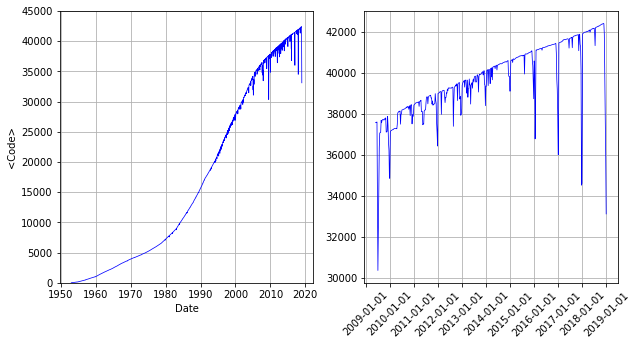

In [3]:
# TO SKIP -- plot setup

mean_ = chart_df[chart_df != -1].mean(axis = 1).values

fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 5)

axes[0].plot(chart_df.index.to_pydatetime(), mean_, color = 'blue', linewidth = 0.75)
axes[0].set_ylim((0, 45000)); axes[0].grid(True)
axes[0].set_ylabel("<Code>"); axes[0].set_xlabel('Date')
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

axes[1].plot(chart_df.index.to_pydatetime()[-500:], mean_[-500:], color = 'blue', linewidth = 0.75)
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'));

axes[1].grid(True)
axes[0].set_xlabel('Date')

for tick in axes[1].get_xticklabels():
        tick.set_rotation(45)

plt.show()

A curve with a trend of the right sign superimposed with seasonal downward spikes. These spikes appear around Christmas (see right panel above), which indicates they are due to recurring Christmas singles from the previous years. (A few searches in the database also confirmed this.) We therefore set out to investigate the Christmas singles (CS from now on) is this blog post.

## Notation

A few useful definitions and notations are introduced which will be helpful in formalising the analysis.

### Singles

We retain the definition of singles. The set of singles, $S$ is defined as

$$
\mathcal{S} = \big\{ s_{k}, k \in \{1,..., N_{S}\} \big\}, \, \text{where} \\
0 < N_{S}, \quad \text{(no-empty)} \\
\forall k,l, \, k \neq l : s_{k} \neq s_{l} \quad \text{(unique elements)}
$$

### Chart

A chart of $0 < N_{W}$ weeks and $0 < N_{P}$ weekly positions is defined as

$$
\mathbf{C} = \mathcal{S}^{N_{W} \times N_{P}} \quad \text{(rectangular matrix)}\\
\forall i,k : 0 \leq \bigg| \bigcup\limits_{j} \{c_{ij}\} \cap \{s_{k} \} \bigg| \leq 1 \quad \text{(a single can appear at most once in a week)}
$$

$C_{i,.}$ is the $i$- th week of the chart, whereas $C_{j}$ is the $j$-th position across the weeks. 

The chart can also be interpreted as an indexed set with non-unique elements. We will heavily rely on this duality later on. Therefore, $C$ (single font) means the indexed set corresponding to the matrix chart $\mathbf{C}$. 

#### Period

A period is a collection of subsequent rows (_i.e._ weeks) of the chart. A period is be denoted by $c_{[mn]}$ stretching from week $m$ to week $n$.

#### Slice

A slice is a collection of subsequent columns (_i.e._) positions throughout all weeks. A slice between and including positions $m$ and $n$ is denoted by $c_{(mn)}$. It is often convenient to use the shorthand $i = [mn]$ to denote both slices and periods.


### Selection

A selection is a submatrix (or subset) of the chart. It is the intersection of periods and slices.

### Position

The position of the $s_{k}$ single in week $i$ in chart $C$, $v^{C}_{k,i}$ is defined as a result of a query:

$$
v^{C}_{k,i} = \begin{cases} j, \quad & \text{if} \quad \big|\left\{ {j, 0 < j < N_{P}, j : c_{ij} = s_{k}} \right\}\big| = 1 \\ 
                 \text{undefined}, \quad &\text{if} \quad \big|\left\{ {j, 0 < j < N_{P}, j : c_{ij} = s_{k}} \right\}\big| = 0
           \end{cases}
$$

There are no other cases for it has already been ensured that a single can appear at most once a week.

### Time series of a single

A time series, history, progression of a single $s_{k}$ is defined as the succession of weeks and the associated weekly positions wherever the position is defined. Each point consists of the ordered pair of week, $i$ and the position $v^{U}_{k,i}$

$$
    \big((i, v^{C}_{k,i}) \big)_{i = i_{1}}^{i_{n}}, \, \quad \text{(pair of date and position)}\\
    v^{C}_{k,i} \in \{1, ..., N_{P} \}, \, \quad \text{(defined)}  \\
    \forall k,l, \, \, k < l : i_{k} < i_{l} \, \quad \text{(ordered in time)}
$$

### Christmas period

The Christmas period (CP) brackets the weeks immediately preceeding and following the holiday. We define it as period of the chart falling on the subsequent months of December and January. The Christmas period starting in year $y$ is denoted by $C^{C}_{y}$.

### Christmas single

We must define what constitutes a Christmas single. There are two approaches. The first one states that CS is a song that is usually played during multiple Christmas periods. These are easier to identify by looking for singles that appear in more than one CPs. This definition does not state anything about the origin of the song, or the original intent of the artists who produced it. The drawback of this definition that persistent singles that were not intended to be CSs will be accounted as those.

The second definition tries to capture the essence of the CSs. A CS is a song that was intended to be played during Christmas by creating an association between its features and the festive days. In general, it is not at all trivial to determine whether song is a CS just by inspecting the chart. They might only chart in a single year, or their timeseries can be indistinguishable from those of the non-CS singles.

The regretfully non-empty set of CS is denoted by $S_{C}$:

$$
\mathcal{S_{C}} \subset \mathcal{S} \,.
$$

#### Recurring CS

A recurring CS,  is a CS that appears in multiple CPs, or equivalently there are multiple $C^{C}_{y}$-s in which a single appears. The set of recurring CSs are denoted by $S_{CR}$

$$
s_{k} \in S_{CR} \Leftrightarrow   \big| \big\{ y \in \{1,..,N_{y}\}, s_{k} \in \mathcal{C}: s_{k} \in C^{C}_{y} \big\} \big| > 1
$$

The recurring Christmas singles constitute a subset of Christmas singles.

#### Useful notations

The non-unique set of singles in period $i$ is denoted by $c_{i}$. The unique set of singles in period $i$ is denoted by $u_{i}$.

### Notes

The number of weekly positions of the UK singles chart has changed over time, thus the actual chart is not rectangular. It is easy amend this by defining the missing data element $\epsilon$ and define the chart as $C = \big(S \cup \{\epsilon\} \big)^{N_{w}\times N_{P}}$.

## Aim

We aim to answer two questions

* What is the prevalence of recurring Christmas singles?
* Is it worth to issue a Christmas single? (If you ask me, it is definitely not.)

We restrict our attention to recurring CSs which are possible to indentify based on their chart positions without any knowledge about their textual or melodic properties.


## Limitations

We will only investigate the top forty positions throughout the years. By doing so, the contamination from persistent non-Christmas singles is mitigated to some extent.


## Analysis

### Prevalence of outliers

Before we spend too much time answering these questions we should investigate how pronounced the recurrence of CS's is. For this end, the overlap is calculated between all months.

The overlap, $o_{i,j}$ between periods $u^{i}$ and $u^{j}$ is defined as the number of singles present in both period divided by the number of singles of period which has fewer of them. 

$$
o_{ij} = \frac{ |c^{C}_{i} \cap c^{C}_{j}| }{\min(|c^{C}_{i}|, |c^{C}_{j}|)}
$$

The overlap is unit if one set is contained in the other, and zero if they have no elements/singles in common. Our (resonably) efficient [Tversky index algorithm](https://bhornung.github.io/python/2019/03/05/tversky-index.html) will be used.

In [4]:
unique_in_months = chart_df.groupby((chart_df.index.year, chart_df.index.month)).apply(lambda x: np.unique(x.values.flat))

um = [np.array(x[x != -1], dtype = np.int32) for x in  unique_in_months.values]
overlap = calculate_pairwise_tversky(um, 1.0, 1.0)

C:\Users\hornu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  """Entry point for launching an IPython kernel.


The overlap is plotted below. 
* Each horizontal line shows the overlap with the charts from previous years.
* The diagonal is unit for each month totally overlaps with itself. 
* The blue band above the diagonal is due to singles which chart for more than one consecutive months. 
* The isolated dots signify singles which disappear from the charts for some time then reappear.
* These singles constitute a grid that falls on the Decembers.
* It is worth noting, the apparent lifetime of singles radically increases after 2000. We will investigate this phenomenon elsewhere.

No handles with labels found to put in legend.
No handles with labels found to put in legend.


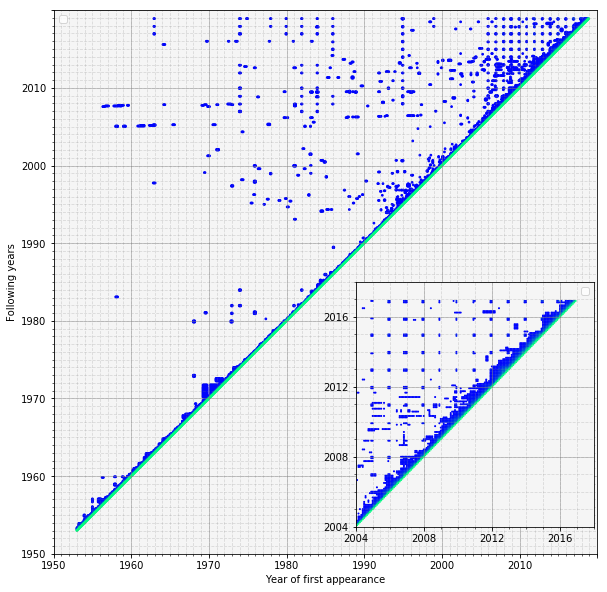

In [5]:
# TO SKIP -- plot setup

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 10)

xticks = [0, 120, 240, 360, 480, 600, 720, 840]
xticks = yticks = [x-36 for x in xticks]
xticklabels = yticklabels = ['1950', '1960','1970', '1980','1990', '2000','2010']

plot_kwargs = {'xlabel' : "Year of first appearance",'ylabel' : "Following years",
               'xmin' : -3, 'xmax' : 67, 'ymin' : -3, 'ymax' : 67,
               'xticks' : xticks, 'xticklabels' : xticklabels,
               'yticks' : yticks, 'yticklabels' : yticklabels,
               'minor_ticks' : 12}

plot_scatter_histo(overlap, ax, plot_kwargs = plot_kwargs, scatter_kwargs = {'marker' : '.', 'size' : 12})

inset_data = overlap[:, overlap[0] > 636] 
axins = ax.inset_axes([0.55, 0.05, 0.45, 0.45])
                   
plot_scatter_histo(inset_data, axins, scatter_kwargs = {'marker' : '.', 'size' : 4},
              plot_kwargs = {'xmin' : 636, 'xmax' : 804, 'ymin' : 636, 'ymax' : 804,
                             'xticks' : [636, 684, 732, 780], 'xticklabels' : ['2004', '2008', '2012', '2016'],
                             'yticks' : [636, 684, 732, 780], 'yticklabels' : ['2004', '2008', '2012', '2016'],
                             'minor_ticks' : 12})

plt.show()

### Characteristics of recurrent Christmas singles

We defined the recurring Christmas singles as those singles which appear in mutiple Christmas periods. They can easily be selected by forming the union of all intersections of unique singles in each Christmas period.

#### Number

$$
S_{CR} = \bigcup\limits_{i<j} u^{C}_{i} \cap u^{C}_{j}
$$

The number of recurring CSs is surprisingly small being 56.

#### Contamination

There are two issues with the current definition:
* we are blind (unfortunately, not deaf) to CSs which only appear in a single period
* singles can persist for year or more in the charts. It could be that a non-CS (NCS) appear in multiple CPs therefore it is accounted as a CS.

In order to gauge the latter effect the charts are decomposed to CSs and NCSs. They are separated the `chart_xmas_df` and `chart_nx_df` dataframes, respectively. The 2D overlap graphs, along with the histogram of overlaps are shown below.

In [6]:
# select December and January
xmas_mask = (chart_df.index.month == 12) | (chart_df.index.month == 1)

# group December with following January
xmas_grouper = lambda x: x.year - 1953 + x.month // 12

# xmas singles
chart_xmas_df = chart_df.loc[xmas_mask]

# non xmas singles
chart_nx_df = chart_df.loc[~xmas_mask]

In [7]:
# TO SKIP -- boring

unique_xmas = chart_xmas_df.groupby(xmas_grouper(chart_xmas_df.index)).apply(lambda x: np.unique(x.values.flat))
um_xmas = [np.array(x[x != -1], dtype = np.int32) for x in  unique_xmas.values]
overlap_xmas = calculate_pairwise_tversky(um_xmas, 1.0, 1.0)

# non xmas singles
unique_nx = chart_nx_df.groupby((chart_nx_df.index.year)).apply(lambda x: np.unique(x.values.flat))
um_nx = [np.array(x[x != -1], dtype = np.int32) for x in  unique_nx.values]
overlap_nx = calculate_pairwise_tversky(um_nx, 1.0, 1.0)

# all singles
unique_all = chart_df.groupby(xmas_grouper(chart_df.index)).apply(lambda x: np.unique(x.values.flat))
um_all = [np.array(x[x != -1], dtype = np.int32) for x in  unique_all.values]
overlap_all = calculate_pairwise_tversky(um_all, 1.0, 1.0)

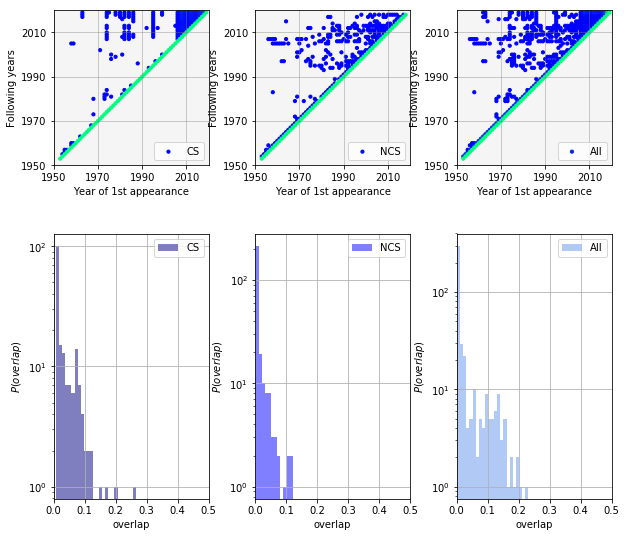

In [8]:
# TO SKIP -- plot setup

fig, axes = plt.subplots(2, 3, gridspec_kw = {'wspace' : 0.3, 'hspace' : 0.05})
fig.set_size_inches(10, 10)

plot_kwargs = {'xlabel' : "Year of 1st appearance",'ylabel' : "Following years",
               'xmin' : -3, 'xmax' : 67, 'ymin' : -3, 'ymax' : 67,
               'xticks' : [-3, 17, 37, 57], 'xticklabels' : ['1950', '1970', '1990', '2010'],  
               'yticks' : [-3, 17, 37, 57], 'yticklabels' : ['1950', '1970', '1990', '2010']}

plot_kwargs.update({'label' : 'CS'})
plot_scatter_histo(overlap_xmas, axes[0,0], plot_kwargs= plot_kwargs)
plot_kwargs.update({'label' : 'NCS'})
plot_scatter_histo(overlap_nx, axes[0,1], plot_kwargs= plot_kwargs)
plot_kwargs.update({'label' : 'All'})
plot_scatter_histo(overlap_all, axes[0,2], plot_kwargs= plot_kwargs)

# histograms
plot_kwargs = {'xmin' : 0, 'xmax' : 0.5, 'xlabel' : r'overlap', 'ylabel' : r'$P(overlap)$' ,'logy' : 1, 'label' : 'CS'}
plot_histo(overlap_xmas[2], axes[1,0], 'navy', plot_kwargs = plot_kwargs)
plot_kwargs.update({'label' : 'NCS'})
plot_histo(overlap_nx[2], axes[1,1], 'blue', plot_kwargs = plot_kwargs)
plot_kwargs.update({'label' : 'All'})
plot_histo(overlap_all[2], axes[1,2], 'cornflowerblue', plot_kwargs = plot_kwargs)

plt.show()

The overlap plots are different. The CS one has a grid-like structure, whilst the NCS plot is more random. The overlap plot of all singles is the weighted average of the previous two. Ideally, the NCS overlap would be zero, or much smaller than the overlap between CSs. The histograms show it otherwise. This is a potential issue, for the CSs are likely to be contaminated with recurring non Christmas singles.

Nevertheless, we proceed to develop a framework to analyse Christmas singles. The following machinery, in itself, does not depend on the definition of CSs, therefore it can be transferred to a scenario where the set of CSs are delineated more carefully.

### Statistics by years

We develop a handful of measures to quantify the similarity and prevalence of singles. The term "year" will refer to the Christmas period of a year in the following.

Let,
* $|c^{C}_{i}| = N^{p}_{i}$, the number of positions in year $i$.
* $|f^{C}_{i}| = N^{u}_{i}$  the number of unique labels in year $i$.
* $n^{p}_{ij}$ the number of positions taken up singles which **first** appeared in year $j$, in year $i$.
* $n^{u}_{ij}$ the number of unique singles which first appeared in year $j$, in year $i$.

#### Retrospective or backward looking statistics

The probability that a single is from year $j$ given the year is $i$ is equal to: 

$$
P_{B}(j | i) = \frac{n^{p}_{ij}}{N^{P}_{i}}, \quad j < i
$$

The cumulative probability reflects how strong absorber of past singles a particular year is:

$$
F_{B}(i) = P(j<i|i) = \sum\limits_{i<j} \frac{n^{p}_{ij}}{N^{p}_{i}}
$$

Similar probabilities can also be derived using the counts of the unique singles.

#### Forward looking statistics

There are two potential types of measures. 

##### Overlap

The probability that a single **first issued and selected from** year $i$ appear in year $j$ is equal to:

$$
P_{U}(j | i) = \frac{n^{u}_{ji}} {N^{u}_{i}}, \quad i < j
$$

The cumulative probability would show what is the likelihood that a single first appeared in year $i$ reappears in any of the following year. It is not possible to calculate this quantity given only the counts and it is of modes interest.

##### Coverage

The other forward looking aspect measures how strongly a year contribute to the charts in the following years. The probability that a single is from year $i$ given the year is $j$ is equal to: 

$$
P_{F}(j | i) = \frac{n^{p}_{ji}}{N^{p}_{j}}, \quad i < j 
$$

The cumulative probability tells us how strong emitter a certain year is:

$$
F_{F}(i) =  P_{F}(i < j|i) = \sum\limits_{j<i} \frac{n^{p}_{ji}}{N^{p}_{j}}
$$

Using $F_{B}$ and $F_{F}$ one can tell how strong absorber or emitter a year is. The density functions, $P_{B}$, $P_{F}$ can be invoked to extablish the degree of various types of similarities between years.

The backward and forward cumulative number ratios are shown below.

In [9]:
# TO SKIP -- boring

xmas_numbers = chart_xmas_df.groupby(xmas_grouper(chart_xmas_df.index)).apply(lambda x: Counter(x.values.flat))
_ = deque((x.pop(-1, None) for x in xmas_numbers))

number_ratio_backward = calculate_backward_number_ratio(xmas_numbers)
number_ratio_forward = calculate_forward_number_ratio(xmas_numbers)

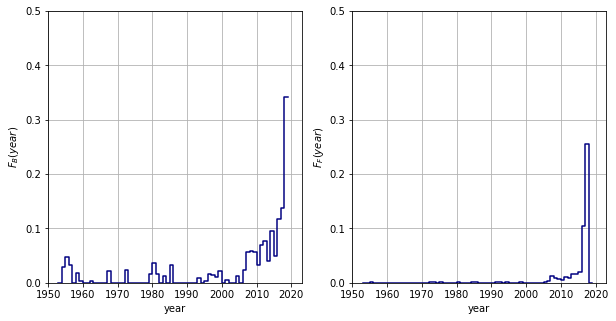

In [10]:
# TO SKIP -- plot setup

data = (number_ratio_backward, number_ratio_forward)

labels = (r'$F_{B}(year)$', r'$F_{F}(year)$')
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 5)

for ax, dt, label in zip(axes, data, labels):
    ax.step(np.arange(dt.size), dt, c = 'navy')
    ax.grid(True)
    ax.set_xlabel('year'); ax.set_ylabel(label)
    ax.set_xlim((-3,70)); ax.set_ylim((0,0.5))
    ax.set_xticks(np.arange(-3,77,10))
    xlabels = [str(int(x + 1953)) for x in ax.get_xticks()]
    ax.set_xticklabels(xlabels)
    
plt.show()

The ratio of the singles issued in preceeding years are shown in the let panel.
* maximum 5% of the positions are populated by old singles for the first fice decades
* after 2000, this ratio dramatically increases, perhaps, due to, background NCS singles

The forward statistics looks as expected.
* the probability that an early single covers large swathes of the future positions is negligible
* in the present decade, there is a large contribution from singles from the preceeding years.

#### Single network

The backward looking probability disitribution function, $P_{B}$, spans a graph.

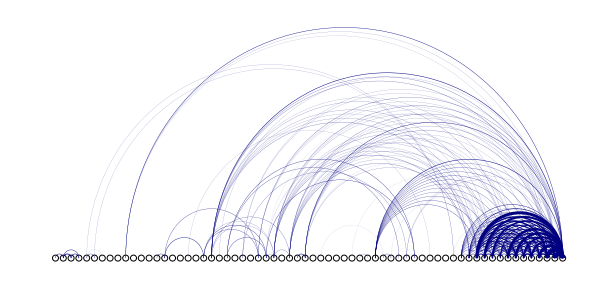

In [11]:
# TO SKIP -- plot setup

rbr = calculate_backward_resolved_number_ratio(xmas_numbers)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 5)
plot_linear_graph(rbr, ax)
plt.show()

Each black circle corresponds to a year. If a singe appeared in year $i$ and recharted in year $j$ a blue arc connects the two years. The width of which is proportional to the contribution to year $j$, $(P_{B}(j|i))$. Arcs are not drawn between two reappearances. Plus points are awarded for indentifying "Rocking around the Christmas tree" and "Do they know it's Christmas?".

#### Years of similar taste

Expanding on the idea of the graph representation, one can create a network of years based on how similar their respective charts are. There is a plethora of similarity measures. We choose to gauge similarity by the normalised intersection of two non-unique sets:

$$
= \frac{|u^{C}_{i} \cap u^{C}_{j}|} {|u^{C}_{i} \cup u^{C}_{j}|}, 
$$

which is the wieghted Jaccard index of two charts. Arcs are now drawn between reappearances.

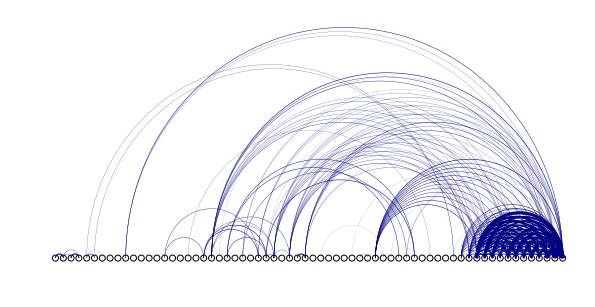

In [12]:
# TO SKIP -- plot setup

jaccard = calculate_weighted_jaccard(xmas_numbers)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 5)
plot_linear_graph(jaccard, ax)
plt.show()

#### Clustering years

A logical next step is to group years by their similarities. We are going to use a [Markov cluster algoritm](https://github.com/bhornung/MCA). Each group of years coloured by the same colour have similar charts.

In [13]:
sys.path.append(r'C:\Users\hornu\OneDrive\Documents\repos\MCA\source')
from MCAsparse.MCAsparse import MCsparse
from scipy.sparse import coo_matrix
 
# prepare distance matrix
jaccard = calculate_weighted_jaccard(xmas_numbers, with_diag = True)
X = coo_matrix((jaccard[2], (jaccard[0].astype(np.int32), jaccard[1].astype(np.int32)))).tocsr()

clusterer = MCsparse(inflate_power = 1.111, max_iter = 100, save_steps= True)
labels = clusterer.fit_predict(X)

Iteration 0 : diff 2.280421556247735
Iteration 1 : diff 2.8697980854370173
Iteration 2 : diff 3.5428997656550267
Iteration 3 : diff 4.241808460049173
Iteration 4 : diff 4.871277805850764
Iteration 5 : diff 5.327054947698631
Iteration 6 : diff 5.598195936745873
Iteration 7 : diff 5.806812008869492
Iteration 8 : diff 6.365397210983668
Iteration 9 : diff 7.940116158448506
Iteration 10 : diff 8.64758296100597
Iteration 11 : diff 7.216363526240651
Iteration 12 : diff 7.347741508246964
Iteration 13 : diff 7.48401800594423
Iteration 14 : diff 6.190561094341679
Iteration 15 : diff 5.211999673031375
Iteration 16 : diff 4.4189284054283
Iteration 17 : diff 3.068710572826375
Iteration 18 : diff 2.3823739321499278
Iteration 19 : diff 2.0030739752902624
Iteration 20 : diff 1.1679030001744055
Iteration 21 : diff 0.3960083444238315
Iteration 22 : diff 0.13552318798914187
Iteration 23 : diff 0.1475715813894027
Iteration 24 : diff 0.2237877910461696
Iteration 25 : diff 0.33867856862970214
Iteration 26 :

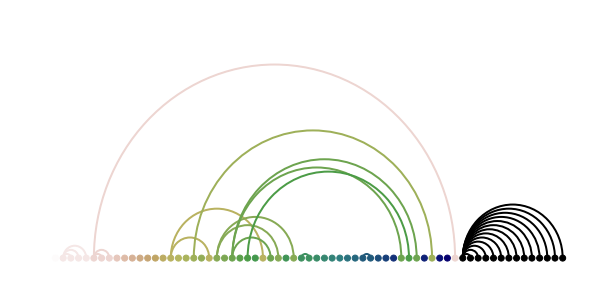

In [14]:
# TO SKIP -- plot setup

cluster_graph = np.stack([clusterer.mat_list[-1].tocoo().row,
                         clusterer.mat_list[-1].tocoo().col,
                         clusterer.mat_list[-1].tocoo().data])

fig, ax = plt.subplots(1,1)
fig.set_size_inches(10, 5)
cmap = plt.get_cmap('gist_earth_r')
colors = [cmap(x/labels.max()) for x in labels]
plot_linear_graph_with_colors(cluster_graph, ax, colors)

#### Grouping of singles

Each edge in the graph above corresponds to a set of singles. Clustering the years by a similarity measure induces a clustering of singles.

#### Positions

An descriptive quantifier of the performance is the position. It is trivial to query the position of the Christmas singles, hence it is omitted from this discussion.

## Summary

We have created a simple mathematical formalism and a framework composed of the components thereof to analyse recurring singles. We could only approximately identify the set of Christmas singles, due to persistent non Christmas singles.

## Future work

In the next post digressing this topic, we develop two methods to find true Christmas singles. A careful analysis will also be carried out in the realm of the framework that we have developed.